<a href="https://colab.research.google.com/github/alexngocvu/Heart-Disease-and-Lifestyle/blob/main/Heart_Disease_Term_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import warnings #for clean outputs
warnings.filterwarnings(action='ignore')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import chi2_contingency

In [5]:
sns.set(style="whitegrid") #setting style
plt.rcParams['figure.figsize'] = (10, 6)

In [6]:
from google.colab import files #uploading file
uploaded = files.upload()

Saving heart_2020_cleaned.csv to heart_2020_cleaned (1).csv


In [7]:
df = pd.read_csv('heart_2020_cleaned.csv')

In [8]:
print("Data shape:", df.shape) #number of observation and variables

Data shape: (319795, 18)


In [9]:
print(df.head())

  HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No               3   
1           No  20.34      No              No    Yes               0   
2           No  26.58     Yes              No     No              20   
3           No  24.21      No              No     No               0   
4           No  23.71      No              No     No              28   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0            30          No  Female        55-59  White      Yes   
1             0          No  Female  80 or older  White       No   
2            30          No    Male        65-69  White      Yes   
3             0          No  Female        75-79  White       No   
4             0         Yes  Female        40-44  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
0              Yes  Very good          5    Yes            No        Yes  
1       

In [10]:
print("Raw GenHealth values in original df:")
print(df['GenHealth'].unique())
print(df['GenHealth'].value_counts())

Raw GenHealth values in original df:
['Very good' 'Fair' 'Good' 'Poor' 'Excellent']
GenHealth
Very good    113858
Good          93129
Excellent     66842
Fair          34677
Poor          11289
Name: count, dtype: int64


In [11]:
# FINAL PREPROCESSING
import pandas as pd
from sklearn.preprocessing import StandardScaler


# --- 1. Select features ---
features = ['PhysicalActivity', 'GenHealth', 'MentalHealth']
X = df[features].copy()
y = df['HeartDisease'].copy()

# --- 3. Convert Yes/No to 1/0 ---
print("\nBefore conversion:")
print("PhysicalActivity unique:", X['PhysicalActivity'].unique())
print("HeartDisease unique:", y.unique())

# Fix PhysicalActivity
X['PhysicalActivity'] = X['PhysicalActivity'].map({'Yes': 1, 'No': 0})

# Fix target (HeartDisease)
y = y.map({'Yes': 1, 'No': 0})

print("After conversion:")
print("PhysicalActivity unique:", X['PhysicalActivity'].unique())
print("HeartDisease unique:", y.unique())

# --- 4. Fix GenHealth ---
genhealth_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
genhealth_map = {val: idx for idx, val in enumerate(genhealth_order)}
X['GenHealth'] = X['GenHealth'].map(genhealth_map)

# --- 5. Check for NaNs ---
print("\nNaNs after mapping:")
print(X.isnull().sum())

assert X.isnull().sum().sum() == 0, "Still NaNs! Check mapping."
assert y.isnull().sum() == 0, "HeartDisease has NaNs!"

# --- 6. Final X (all numeric) ---
print("\nX dtypes (should all be number):")
print(X.dtypes)

# --- 7. Scale ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=X.index)

print(f"\nScaling successful! X_scaled_df shape: {X_scaled_df.shape}")
print("First 3 rows:")
print(X_scaled_df.head(3))


Before conversion:
PhysicalActivity unique: ['Yes' 'No']
HeartDisease unique: ['No' 'Yes']
After conversion:
PhysicalActivity unique: [1 0]
HeartDisease unique: [0 1]

NaNs after mapping:
PhysicalActivity    0
GenHealth           0
MentalHealth        0
dtype: int64

X dtypes (should all be number):
PhysicalActivity    int64
GenHealth           int64
MentalHealth        int64
dtype: object

Scaling successful! X_scaled_df shape: (319795, 3)
First 3 rows:
   PhysicalActivity  GenHealth  MentalHealth
0          0.538256   0.388307      3.281069
1          0.538256   0.388307     -0.490039
2          0.538256  -1.529392      3.281069


In [12]:
# Handle missing values (if any) ---
print("Missing values:\n", X.isnull().sum())
X = X.dropna()  # Simple: drop rows with NaN (or impute later)
y = y[X.index]  # Keep target aligned

Missing values:
 PhysicalActivity    0
GenHealth           0
MentalHealth        0
dtype: int64


In [13]:
# Convert back to DataFrame for readability
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=X.index)

# ------------------- 4. K-MEANS CLUSTERING -------------------
# --- Elbow Method to find optimal k ---
inertias = []
sil_scores = []
K = range(2, 8)  # Try 2 to 7 clusters

Using 10,000 points for elbow + silhouette
k=2 → inertia=19110, silhouette=0.517
k=3 → inertia=12097, silhouette=0.562
k=4 → inertia=8110, silhouette=0.547
k=5 → inertia=7104, silhouette=0.580
k=6 → inertia=5159, silhouette=0.583
k=7 → inertia=4171, silhouette=0.632


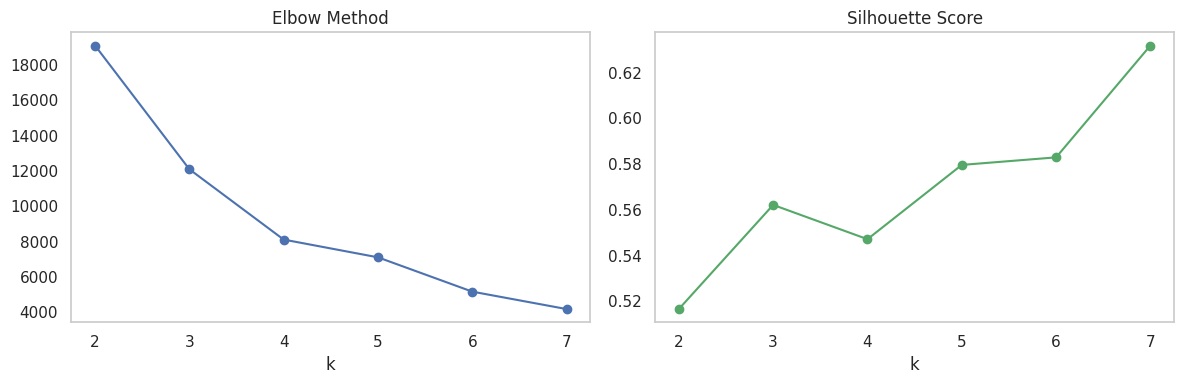


Use k = 4 for final model


In [14]:
# SILHOUETTE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Use a STRATIFIED sample of 10,000 points
np.random.seed(42)
sample_size = 10_000
sample_idx = np.random.choice(X_scaled_df.index, sample_size, replace=False)
X_sample = X_scaled_df.loc[sample_idx]

print(f"Using {sample_size:,} points for elbow + silhouette")

inertias = []
sil_scores = []
K = range(2, 8)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
    kmeans.fit(X_sample)
    inertias.append(kmeans.inertia_)

    # Silhouette on the *same* sample (fast!)
    score = silhouette_score(X_sample, kmeans.labels_)
    sil_scores.append(score)

    print(f"k={k} → inertia={kmeans.inertia_:.0f}, silhouette={score:.3f}")

# Plot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(K, inertias, 'bo-'); plt.title('Elbow Method'); plt.xlabel('k'); plt.grid()
plt.subplot(1,2,2); plt.plot(K, sil_scores, 'go-'); plt.title('Silhouette Score'); plt.xlabel('k'); plt.grid()
plt.tight_layout(); plt.show()

# Pick k (always pick the elbow unless the silhouette strongly disagrees)
optimal_k = 4  # Change after seeing plot
print(f"\nUse k = {optimal_k} for final model")

In [15]:
# FINAL: Full clustering with best k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled_df)  # Full data, fast!

df_clustered = df.copy()
df_clustered['Cluster'] = cluster_labels
print("Full clustering done!")

Full clustering done!


In [16]:
# --- FINAL: Add clusters correctly ---
# X_scaled_df has same index as X (cleaned data)
df_clustered = X.copy()  # Start with numeric features
df_clustered['Cluster'] = cluster_labels  # Add cluster

# Join back HeartDisease and any other original columns
df_clustered = df_clustered.join(df[['HeartDisease']], how='left')

print("Clustering added! Shape:", df_clustered.shape)

Clustering added! Shape: (319795, 5)


In [17]:
# --- Cluster profiles ---
features = ['PhysicalActivity', 'GenHealth', 'MentalHealth']
cluster_profile = df_clustered.groupby('Cluster')[features].mean().round(2)
print("\nCluster Profiles (mean values):")
print(cluster_profile)

# Map GenHealth back to words
genhealth_words = {0: 'Poor', 1: 'Fair', 2: 'Good', 3: 'Very good', 4: 'Excellent'}
cluster_profile['GenHealth'] = cluster_profile['GenHealth'].round(0).astype(int).map(genhealth_words)

print("\nInterpretable Cluster Profiles:")
print(cluster_profile)


Cluster Profiles (mean values):
         PhysicalActivity  GenHealth  MentalHealth
Cluster                                           
0                    1.00       3.39          1.58
1                    0.00       2.16          1.88
2                    0.64       1.83         27.30
3                    1.00       1.73          2.15

Interpretable Cluster Profiles:
         PhysicalActivity  GenHealth  MentalHealth
Cluster                                           
0                    1.00  Very good          1.58
1                    0.00       Good          1.88
2                    0.64       Good         27.30
3                    1.00       Good          2.15



% Heart Disease by Cluster:
HeartDisease     No    Yes
Cluster                   
0             96.41   3.59
1             86.80  13.20
2             87.94  12.06
3             87.00  13.00


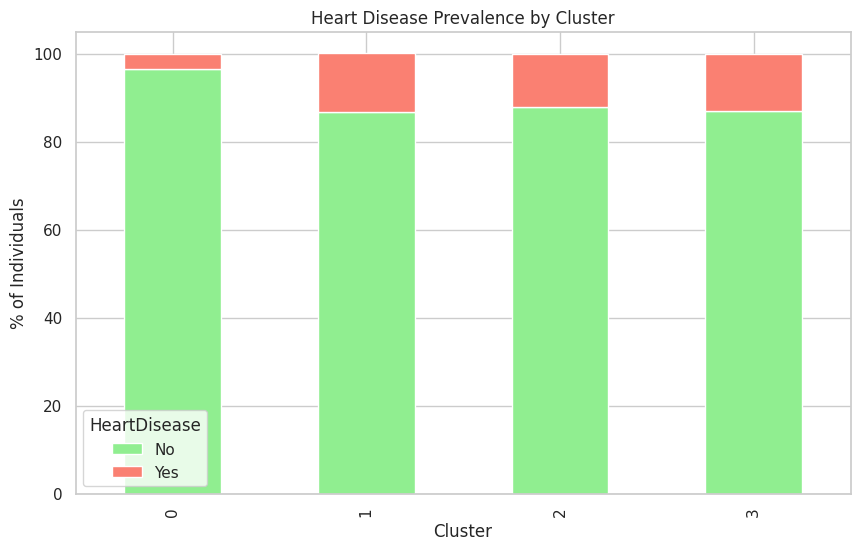

In [18]:
# --- Cross-tab: Clusters vs HeartDisease ---
ctab = pd.crosstab(df_clustered['Cluster'], df_clustered['HeartDisease'],
                   normalize='index') * 100
print("\n% Heart Disease by Cluster:")
print(ctab.round(2))

# Visualize
ctab.plot(kind='bar', stacked=True, color=['lightgreen', 'salmon'])
plt.title('Heart Disease Prevalence by Cluster')
plt.ylabel('% of Individuals')
plt.legend(title='HeartDisease', labels=['No', 'Yes'])
plt.show()

In [19]:
# --- Chi-square test ---
contingency_table = pd.crosstab(df_clustered['Cluster'], df_clustered['HeartDisease'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square test: χ² = {chi2:.2f}, p-value = {p:.4f}")
if p < 0.05:
    print("→ Significant association: Clusters relate to HeartDisease!")
else:
    print("→ No significant association.")


Chi-square test: χ² = 8910.85, p-value = 0.0000
→ Significant association: Clusters relate to HeartDisease!


Using 5,000 points for dendrogram


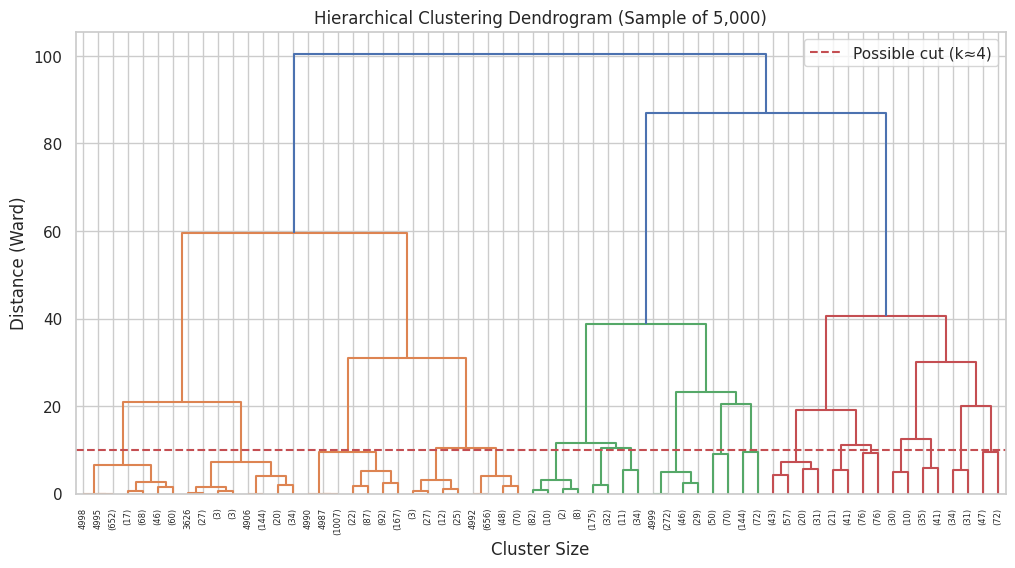


Hierarchical Silhouette Score (k=4, on sample): 0.537


In [20]:
# HIERARCHICAL CLUSTERING (FAST & SAFE)
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Use SMALL sample for dendrogram (5,000 max)
sample_size = min(5000, len(X_scaled_df))
sample_idx = np.random.choice(X_scaled_df.index, sample_size, replace=False)
X_sample = X_scaled_df.loc[sample_idx]

print(f"Using {sample_size:,} points for dendrogram")

# 2. Build linkage (fast on small sample)
linked = linkage(X_sample, method='ward')

# 3. Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=5, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram (Sample of 5,000)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance (Ward)')
plt.axhline(y=10, color='r', linestyle='--', label='Possible cut (k≈4)')
plt.legend()
plt.show()

# 4. Run hierarchical clustering on SAME SAMPLE
hier = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hier_labels = hier.fit_predict(X_sample)  # ← Only on sample!

# 5. Silhouette on sample
sil_hier = silhouette_score(X_sample, hier_labels)
print(f"\nHierarchical Silhouette Score (k={optimal_k}, on sample): {sil_hier:.3f}")

In [23]:
# FINAL SUMMARY
print("\n" + "="*60)
print("RESEARCH SUMMARY")
print("="*60)

# Extract the silhouette score for k=4 from the list
kmeans_sil = sil_scores[optimal_k - 2]  # k=4 → index 2 (since list starts at k=2)

print(f"• Optimal clusters (k): {optimal_k}")
print(f"• K-Means Silhouette (k={optimal_k}): {kmeans_sil:.3f}")
print(f"• Hierarchical Silhouette (k={optimal_k}): {sil_hier:.3f}")
print(f"• Chi-square p-value: {p:.4f} → {'Significant' if p < 0.05 else 'Not significant'}")
print("• Check bar plot: Do high-risk clusters have more heart disease?")
print("• Use cluster profiles to define personas (e.g., 'Sedentary + Poor Health')")
print("="*60)


RESEARCH SUMMARY
• Optimal clusters (k): 4
• K-Means Silhouette (k=4): 0.547
• Hierarchical Silhouette (k=4): 0.537
• Chi-square p-value: 0.0000 → Significant
• Check bar plot: Do high-risk clusters have more heart disease?
• Use cluster profiles to define personas (e.g., 'Sedentary + Poor Health')
